# Universal theorem of approximation

In [15]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
%matplotlib notebook
import seaborn as sns
sns.set()

In [16]:
def my_func(x):
    return 1/(1+25*x**2)

In [17]:
class FF_nL(torch.nn.Module):
    def __init__(self, d, width=1000, n_in_layer=1):
        super(FF_nL, self).__init__()
        self.fc = nn.Linear(d, width)
        self.relu = torch.nn.ReLU()
        layers = [nn.Sequential(nn.Linear(width, width), nn.ReLU()) for _ in range(n_in_layer)]
        self.layers = nn.Sequential(*layers)
        self.fc_out = nn.Linear(width, 1)
    
    def forward(self, x):
        out = self.fc(x)
        out = self.relu(out)
        out = self.layers(out)
        out = self.fc_out(out)
        return out

In [18]:
n_points = 2000
x = np.linspace(-1, 1, n_points)
y = my_func(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3)
x_train, x_test, y_train, y_test = torch.tensor(x_train), torch.tensor(x_test), torch.tensor(y_train), torch.tensor(y_test)
x_train, x_test, y_train, y_test = x_train.type(torch.FloatTensor), x_test.type(torch.FloatTensor), y_train.type(torch.FloatTensor), y_test.type(torch.FloatTensor)

Preparing the dataset

In [19]:
torch.manual_seed(30)
torch.use_deterministic_algorithms(True)

model_1l = FF_nL(1, width=100, n_in_layer=1)
model_3l = FF_nL(1, width=100, n_in_layer=3)
model_1l.train()
model_3l.train()

optimizer_1l = torch.optim.SGD(model_1l.parameters(), lr=1e-2, weight_decay=1e-5)
optimizer_3l = torch.optim.SGD(model_3l.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler_1l = torch.optim.lr_scheduler.MultiStepLR(optimizer_1l, milestones=[150], gamma=0.1)
scheduler_3l = torch.optim.lr_scheduler.MultiStepLR(optimizer_3l, milestones=[150], gamma=0.1)

loss_func = torch.nn.MSELoss()

train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=20, shuffle=True)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=20, shuffle=True)

The animation

<IPython.core.display.Javascript object>


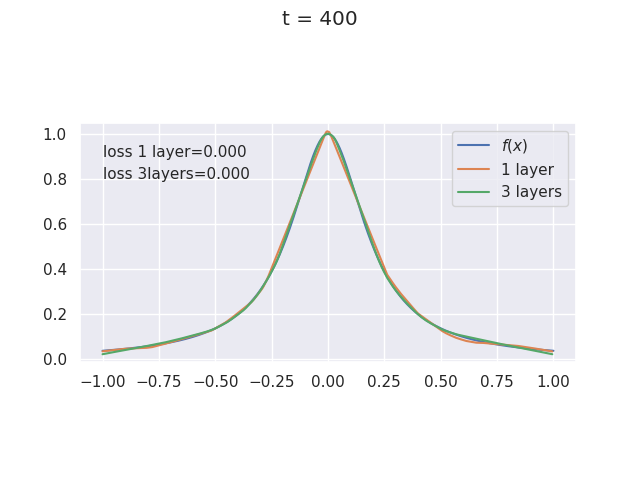

In [14]:
fig, ax = plt.subplots(1,1) # initialise la figure
ax.plot(x, y, label=r"$f(x)$")
line_1l, = ax.plot([],[], label="1 layer") 
line_3l, = ax.plot([],[], label="3 layers") 
xmin, xmax = -1, 1
tmp = 0
ax.set_aspect(aspect="equal")

sub_sample = 1
n_frames = 199


loss_1l = ax.text(xmin, .90, '', fontsize=11)
loss_3l = ax.text(xmin, .8, '', fontsize=11)
plt.legend()

def animate(i):
    global tmp
    
    valid_loss_1l = 0.
    model_1l.train()
    for i in range(sub_sample):
        for x, y in train_loader:
            x = x.view(-1, 1)
            optimizer_1l.zero_grad()
            y_pred = model_1l(x)
            loss = loss_func(y_pred.flatten(), y)
            loss.backward()
            optimizer_1l.step()
        scheduler_1l.step()
    model_1l.eval()
    with torch.no_grad():
        for x, y in test_loader:
            y_pred = model_1l(x.view(-1, 1))
            loss = loss_func(y_pred.flatten(), y)
            valid_loss_1l += loss.item()*x.size(0)
        valid_loss_1l /= len(test_loader.sampler)
        line_1l.set_data(torch.sort(x_test)[0], model_1l(torch.sort(x_test)[0].view(-1, 1)))
                
    loss_1l.set_text(f"loss 1 layer={valid_loss_1l:.3f}")

    valid_loss_3l = 0.
    model_3l.train()
    for i in range(sub_sample):
        for x, y in train_loader:
            optimizer_3l.zero_grad()
            y_pred = model_3l(x.view(-1, 1))
            loss = loss_func(y_pred.flatten(), y)
            loss.backward()
            optimizer_3l.step()
        scheduler_3l.step()
    model_3l.eval()
    with torch.no_grad():
        for x, y in test_loader:
            y_pred = model_3l(x.view(-1, 1))
            loss = loss_func(y_pred.flatten(), y)
            valid_loss_3l += loss.item()*x.size(0)
        valid_loss_3l /= len(test_loader.sampler)
        line_3l.set_data(torch.sort(x_test)[0], model_3l(torch.sort(x_test)[0].view(-1, 1)))
    loss_3l.set_text(f"loss 3layers={valid_loss_3l:.3f}")

    tmp += sub_sample
    fig.suptitle('t = %i' % (tmp))
    return line_3l, line_1l, loss_1l, loss_3l
 
ani = animation.FuncAnimation(fig, animate, frames=n_frames, blit=False, interval=100, repeat=False)
ani.save("../tex/videos/universal_approx.mp4", dpi=100)